In [1]:
import pandas as pd
from models import efficient_net
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from sklearn.utils.class_weight import compute_class_weight

from modeling import predict_from_csv, stacking_from_csv, train_classifier
from src import InputPipeline

%load_ext autoreload
%autoreload 2

## Check GPU for tf

In [2]:
# Some GPU setup
# for documentation about using gpus refer to: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.80)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

### Optional Stuff
- Here we compute classweights since the data is very imbalanced

In [3]:
train_df = pd.read_csv("../data/train_images_stratified.csv")

In [4]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = train_df["label"].unique(), y=train_df["label"])
class_weights = dict(enumerate(class_weights))

## Configure Parameters

In [5]:
INPUT_SHAPE = (220,220,3)

CONF = {
  "learning_rate": 0.001,
  "batch_size": 48,
  "epochs": 60,
  "loss_function": "sparse_categorical_crossentropy",
  "metric": "sparse_categorical_accuracy",
}

## Make Input Pipelines

In [6]:
# Input pipeline for subspecies
sub_species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
# This has a stratified split
sub_species_input_pipeline.make_stratified_train_dataset(
  train_ds_path= "../data/train_ds_images_stratified.csv",
  val_ds_path="../data/val_ds_images_stratified.csv",
)

# Input pipeline for species
species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
species_input_pipeline.make_train_datasets(directory="../data/train_images/species_classify")  # This doesnt have a stratified split

Datasets populated!
Found 43186 files belonging to 70 classes.
Using 36709 files for training.
Using 6477 files for validation.
Datasets populated!


## Training a Model

In [7]:
from modeling import train_classifier

In [8]:
# making the species classifier
train_classifier(
  model_name="../classifiers/species_effnet",
  input_shape=INPUT_SHAPE,  
  classes_to_classify=200,
  configuration=CONF,
  model=efficient_net, 
  train_dataset=sub_species_input_pipeline.train_dataset,
  validation_dataset=sub_species_input_pipeline.validation_dataset,
)

Folder '../classifiers/' already exists.
Folder '../classifiers/trainHistoryDict' already exists.
Epoch 1/60


NotFoundError: Graph execution error:

2 root error(s) found.
  (0) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: ../data/train_images/train_images\62\1793_aug_aug1701204980.5563502.jpg : Das System kann die angegebene Datei nicht finden.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: ../data/train_images/train_images\62\1793_aug_aug1701204980.5563502.jpg : Das System kann die angegebene Datei nicht finden.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_26369]

In [10]:
# making the family classifier
train_classifier(
  model_name="../classifiers/family_effnet",
  input_shape=INPUT_SHAPE,
  classes_to_classify=70,
  configuration=CONF,
  model=efficient_net, 
  train_dataset=species_input_pipeline.train_dataset,
  validation_dataset=species_input_pipeline.validation_dataset,
)

Folder '../classifiers/' already exists.
Folder '../classifiers/trainHistoryDict' already exists.
Epoch 1/80
279/279 [==============================] - 71s 195ms/step - loss: 10.7923 - sparse_categorical_accuracy: 0.2065 - val_loss: 8.8906 - val_sparse_categorical_accuracy: 0.4374
Epoch 2/80
279/279 [==============================] - 49s 175ms/step - loss: 8.5915 - sparse_categorical_accuracy: 0.3774 - val_loss: 7.4461 - val_sparse_categorical_accuracy: 0.5214
Epoch 3/80
279/279 [==============================] - 50s 179ms/step - loss: 7.2654 - sparse_categorical_accuracy: 0.4528 - val_loss: 6.3382 - val_sparse_categorical_accuracy: 0.5673
Epoch 4/80
279/279 [==============================] - 50s 175ms/step - loss: 6.2174 - sparse_categorical_accuracy: 0.5036 - val_loss: 5.4566 - val_sparse_categorical_accuracy: 0.6042
Epoch 5/80
279/279 [==============================] - 49s 174ms/step - loss: 5.4004 - sparse_categorical_accuracy: 0.5358 - val_loss: 4.7447 - val_sparse_categorical_acc

INFO:tensorflow:Assets written to: ../classifiers/species_efficient_net_classifier_50e\assets


INFO:tensorflow:Assets written to: ../classifiers/species_efficient_net_classifier_50e\assets


Model saved successfully under: ../classifiers/species_efficient_net_classifier_50e


## NN results

In [14]:
import pickle 
import matplotlib.pyplot as plt
import pandas as pd

with open("../classifiers/trainHistoryDict/eff_net_hyptunning_25e.pkl", 'rb') as file:
    history = pickle.load(file)

history_df = pd.DataFrame(history)

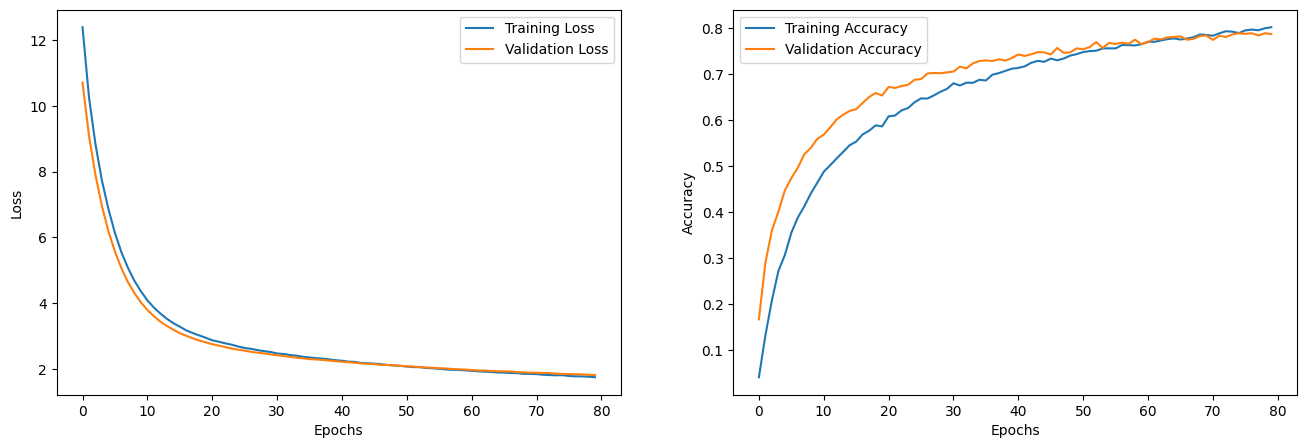

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

# Plot for ax1
ax1.plot(history_df["loss"], label='Training Loss')
ax1.plot(history_df["val_loss"], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for ax2
ax2.plot(history_df["sparse_categorical_accuracy"], label='Training Accuracy')
ax2.plot(history_df["val_sparse_categorical_accuracy"], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.savefig("familyplot.png", dpi=300)

## Predict Stuff

In [5]:
# No label adjustments needed afterwards!!!!!!
predict_from_csv(
  classifier="../classifiers/antonio_effnet_finetune",
  dataset="../data/test_images_path.csv",
  path="../data/test_images",
  size=INPUT_SHAPE,
)

predicting: 100%|██████████| 4000/4000 [09:01<00:00,  7.39it/s]

Saving to: ../data/test_images_sample_1702310237.2045708.csv


## Stacking Prediction

In [13]:
stacking_from_csv(
    primary_classifier="../classifiers/species_efficient_net_classifier_50e",
    secondary_classifier="../classifiers/antonio_effnet_finetune",
    dataset="../data/test_images_path.csv",
    path="../data/test_images",
    size=INPUT_SHAPE,
    weights=(1.0, 0.3),
    mapping="../mapping.pickle",
)

KeyboardInterrupt: 